In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


In [ ]:
import numpy as np
import pandas as pd
import datetime
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import yfinance as yf
import utils.time_series_processing as tsp
import utils.visualisation as vs

In [ ]:
SEQ_LEN = 60
PRED_HORIZON = 22
VAL_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
start_date = "2025-08-01"
end_date   = "2025-09-30"

## Fungsi

In [ ]:
def prepare_data_for_lstm(df, sequence_length=SEQ_LEN, target_length=PRED_HORIZON):

    data_features = df.values

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_features)

    X = []
    Y = []
    all_dates = []

    for i in range(len(df) - sequence_length - target_length + 1):
        X.append(data_scaled[i: i + sequence_length])
        Y.append(data_scaled[i + sequence_length: i + sequence_length + target_length, 0])
        all_dates.append(df.index[i + sequence_length + target_length - 1])

    train_size = int(len(X) * 0.8)

    xt_train = X[:train_size]
    Yl_train = Y[:train_size]
    xt_val = X[train_size:]
    Yl_val = Y[train_size:]

    train_dates = all_dates[:train_size]
    val_dates = all_dates[train_size:]

    # Konversi list ke numpy array
    X_all, y_all = np.array(X), np.array(Y)
    X_train, y_train = np.array(xt_train), np.array(Yl_train)
    X_val, y_val = np.array(xt_val), np.array(Yl_val)

    return scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates

In [ ]:
def inverse_scaler(data, scaler):
    num_features = scaler.scale_.shape[0]

    data_reshape = data.reshape(-1, 1)
    dummy_features = np.zeros((data_reshape.shape[0], num_features - 1))
    data_stack = np.hstack([data_reshape, dummy_features])
    data_inv = scaler.inverse_transform(data_stack)[:, 0]

    return data_inv

In [ ]:
def predict_ensemble(train_models, scaler, last_sequence, meta_model, SEQUENCE_LENGTH=60):
    # Siapkan input dari sequence terakhir
    input_sequence = last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1])

    model_predictions = []

    # Prediksi dari setiap base model
    for model in train_models:
        pred = model.predict(input_sequence, verbose=0)[0]
        model_predictions.append(pred)


    model_predictions_stacked = np.stack(model_predictions, axis=1)
    model_predictions_stacked = model_predictions_stacked.flatten().reshape(1, -1)

    # Prediksi gabungan lewat meta model (output 22 hari sekaligus)
    meta_pred = meta_model.predict(model_predictions_stacked, verbose=0)[0]


    meta_pred = meta_pred.reshape(-1, 1)

    # num_features = scaler.scale_.shape[0]
    # pred = meta_pred.reshape(-1, 1)
    # other_features = np.zeros((pred.shape[0], num_features - 1))

    # meta_pred_stack = np.hstack([pred, other_features])

    # meta_pred_inv = scaler.inverse_transform(meta_pred_stack)[:, 0]

    meta_pred_inv = inverse_scaler(meta_pred, scaler)

    return meta_pred_inv, model_predictions


In [ ]:
def plot_ensemble_predictions(data, scaler, train_dates, val_dates,
                              individual_predictions_train, individual_predictions_val,
                              ensemble_predictions_train, ensemble_predictions_val,
                              future_dates, future_predictions, ticker):

    plt.figure(figsize=(14, 8))

    # Plot data historis (aktual)
    plt.plot(data.index, data['Close'], label='Harga Aktual', color='blue', linewidth=2)

    # Plot prediksi dari model-model individual
    colors = ['lightgray', 'darkgray', 'silver', 'gray']
    # Untuk model individual
    for i, (model_name, preds_train) in enumerate(individual_predictions_train.items()):
        # Plot prediksi train
        plt.plot(train_dates, inverse_scaler(preds_train[:, -1], scaler),
                label=f'{model_name} (Train)', color=colors[i % len(colors)],
                alpha=0.4, linewidth=1, linestyle='--')

        # Plot prediksi validasi jika ada
        if model_name in individual_predictions_val:
            last_step_preds = individual_predictions_val[model_name][:, -1]
            last_step_preds_inverse = inverse_scaler(last_step_preds, scaler)
            plt.plot(val_dates, last_step_preds_inverse,
                    label=f'{model_name} (Val)', color=colors[i % len(colors)],
                    alpha=0.7, linewidth=1, linestyle='-.')

    # Plot ensemble train dan val
    plt.plot(train_dates, inverse_scaler(ensemble_predictions_train[:, -1], scaler), label='Ensemble (Train)', color='green', linewidth=2)
    plt.plot(val_dates, inverse_scaler(ensemble_predictions_val[:, -1], scaler), label='Ensemble (Val)', color='red', linewidth=2, linestyle='--')

    # Plot prediksi masa depan
    plt.plot(future_dates, future_predictions, label='Prediksi masa depan', color='orange', linewidth=2)

    # Garis vertikal untuk hari terakhir aktual
    latest_date = data.index[-1]
    plt.axvline(x=latest_date, color='black', linestyle='--', label='Hari Ini')

    # Judul dan label
    plt.title(f'Prediksi Ensemble Harga Saham {ticker}',
              fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Harga Saham', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_models_future_comparison(df, scaler, future_dates, model_names, y_true, future_predictions_individual, future_predictions_base, ticker):
    """
    future_predictions_individual = [pred_lstm, pred_bilstm, pred_gru]
    model_names = ["LSTM", "BiLSTM", "GRU"]
    """

    data = df.tail(60)

    plt.figure(figsize=(14, 7))

    # Plot data historis
    plt.plot(data.index, data['Close'], label='Historis Aktual', color='blue', linewidth=2)

    # Warna untuk masing-masing base model
    colors = ['red', 'purple', 'brown']

    # Loop berdasarkan index
    for i, preds in enumerate(future_predictions_individual):
        model_name = model_names[i]
        plt.plot(
            future_dates,
            inverse_scaler(preds, scaler),
            label=f'Prediksi {model_name}',
            color=colors[i % len(colors)],
            linewidth=2
        )

    plt.plot(future_dates, y_true, label='Harga Aktual', color='green', linewidth=2)

    plt.plot(future_dates, future_predictions_base, label='Prediksi Ensemble', color='orange', linewidth=2)

    # Garis pemisah antara data historis dan prediksi
    latest_date = data.index[-1]
    plt.axvline(x=latest_date, color='black', linestyle='--', linewidth=1.5, label='Hari Ini')

    # Judul dan styling
    plt.title(f'Perbandingan Hasil Prediksi Harga Saham {ticker} Setiap Model', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Harga Saham', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_future_comparison(scaler, future_dates, model_names, y_true, future_predictions_individual, future_predictions_base, ticker):
    """
    future_predictions_individual = [pred_lstm, pred_bilstm, pred_gru]
    model_names = ["LSTM", "BiLSTM", "GRU"]
    """

    plt.figure(figsize=(14, 7))

    # Warna untuk masing-masing base model
    colors = ['red', 'purple', 'brown']

    # Loop berdasarkan index
    for i, preds in enumerate(future_predictions_individual):
        model_name = model_names[i]
        plt.plot(
            future_dates,
            inverse_scaler(preds, scaler),
            label=f'Prediksi {model_name}',
            color=colors[i % len(colors)],
            linewidth=2
        )

    plt.plot(future_dates, y_true, label='Harga Aktual', color='green', linewidth=2)

    plt.plot(future_dates, future_predictions_base, label='Prediksi Ensemble', color='orange', linewidth=2)

    # Judul dan styling
    plt.title(f'Perbandingan Hasil Prediksi Harga Saham {ticker} Setiap Model', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Harga Saham', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def create_df_predict_future(scaler, future_dates, model_names, y_true, future_predictions_individual, future_predictions_base):

    df_future = pd.DataFrame({
        'Tanggal': future_dates,
    })

    for i, preds in enumerate(future_predictions_individual):
        model_name = model_names[i]
        df_future[f'Prediksi {model_name}'] = inverse_scaler(preds, scaler)

    df_future['Prediksi Ensemble'] = future_predictions_base
    df_future['Harga Aktual'] = y_true

    return df_future


## TLKM

In [ ]:
TICKER = "TLKM"

### Persiapan

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,3386.848145,3437.147869,3353.314995,3437.147869,42258000,-0.234899
2022-07-12,3361.698242,3403.614679,3361.698242,3403.614679,43399800,-0.116959
2022-07-13,3303.015137,3378.464721,3294.631850,3361.698147,96218200,-0.230263
2022-07-14,3370.081543,3370.081543,3269.482094,3303.015244,68708500,-0.182482
2022-07-15,3479.064209,3529.363932,3361.698187,3386.848049,146093800,-0.158824
...,...,...,...,...,...,...
2025-07-25,2820.000000,2830.000000,2780.000000,2810.000000,41296200,-0.066406
2025-07-28,2860.000000,2870.000000,2830.000000,2870.000000,40193800,-0.036199
2025-07-29,2880.000000,2880.000000,2840.000000,2870.000000,46357400,-0.192308


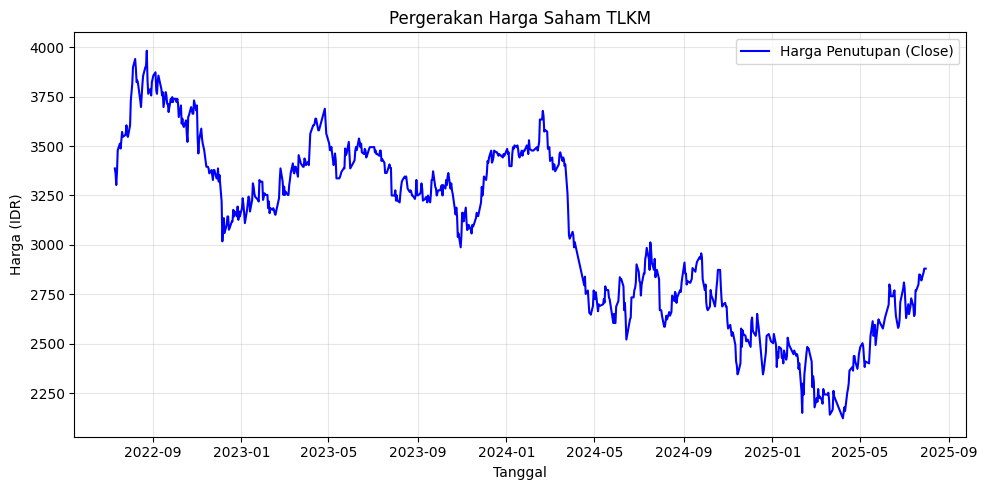

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,3386.848145,42258000,-0.234899
2022-07-12,3361.698242,43399800,-0.116959
2022-07-13,3303.015137,96218200,-0.230263
2022-07-14,3370.081543,68708500,-0.182482
2022-07-15,3479.064209,146093800,-0.158824
...,...,...,...
2025-07-25,2820.000000,41296200,-0.066406
2025-07-28,2860.000000,40193800,-0.036199
2025-07-29,2880.000000,46357400,-0.192308


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

In [ ]:
lstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_lstm_model.keras")
bilstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_bilstm_model.keras")
gru_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_gru_model.keras")
meta_model = tf.keras.models.load_model(f"./model/{TICKER}/meta_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model_names = ["LSTM", "BiLSTM", "GRU"]
models = [lstm_model, bilstm_model, gru_model]

In [ ]:
individual_predictions_train = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_train)
    individual_predictions_train[name] = pred

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [ ]:
individual_predictions_val = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    individual_predictions_val[name] = pred

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
train_preds = list(individual_predictions_train.values())
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=2)
X_stack_train = X_stack_train.reshape(X_stack_train.shape[0], -1)
X_stack_val = np.stack(val_preds, axis=2)
X_stack_val = X_stack_val.reshape(X_stack_val.shape[0], -1)

In [ ]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [ ]:
future_predictions_base, future_predictions_individual = tsp.predict_ensemble(
    models, scaler, last_seq, meta_model)

print(future_predictions_base)

[2847.94328862 2918.02048607 2904.882989   2938.87763061 2922.58590413
 2900.92857994 2906.45680679 2959.78004533 2879.88010376 2970.64428082
 2957.062338   2940.97790134 2966.97711858 2980.356149   2974.7040802
 3016.69165271 2977.56928966 2971.85554924 2957.67295914 3006.42390874
 2987.34643113 2967.58812758]


In [ ]:
print(future_predictions_individual)

[array([0.45211133, 0.44991156, 0.45546508, 0.45543125, 0.44879282,
       0.45019758, 0.4493288 , 0.45757383, 0.44508868, 0.44795674,
       0.44109994, 0.4400017 , 0.44516468, 0.4381824 , 0.43992078,
       0.43407416, 0.4479152 , 0.43972138, 0.44467217, 0.4373086 ,
       0.4416901 , 0.4449518 ], dtype=float32), array([0.38203943, 0.3779481 , 0.37973514, 0.38189813, 0.38441253,
       0.38965502, 0.38362533, 0.38791695, 0.3895004 , 0.39353684,
       0.38494623, 0.38778907, 0.39562672, 0.39501753, 0.38836792,
       0.39539123, 0.39799926, 0.3984037 , 0.39181036, 0.39945108,
       0.39999366, 0.39960274], dtype=float32), array([0.38598654, 0.3860328 , 0.38399112, 0.39454827, 0.3908763 ,
       0.3920766 , 0.39060548, 0.38501537, 0.38975975, 0.39379543,
       0.3925059 , 0.39004362, 0.38449854, 0.39485157, 0.38892567,
       0.3894701 , 0.39242637, 0.388685  , 0.39664987, 0.39170295,
       0.39397374, 0.39311445], dtype=float32)]


In [ ]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base.flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-08-01,2847.943289
2025-08-04,2918.020486
2025-08-05,2904.882989
2025-08-06,2938.877631
2025-08-07,2922.585904
2025-08-08,2900.928580
2025-08-11,2906.456807
2025-08-12,2959.780045
2025-08-13,2879.880104


In [ ]:
df_future  = yf.download(f"{TICKER}.JK", start=start_date, end=end_date)
df_future = df_future[['Close']].dropna()

actual_future = df_future['Close'].head(22).values

/tmp/ipython-input-2396680479.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_future  = yf.download(f"{TICKER}.JK", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
min_len = min(len(future_predictions_base), len(actual_future))

y_true = actual_future[:min_len]
y_pred = future_predictions_base[:min_len]

### Visualisasi

In [ ]:
df_predict_tlkm = tsp.create_df_predict_future(scaler, future_dates, model_names,
                                             y_true, future_predictions_individual, future_predictions_base)

df_predict_tlkm

,Tanggal,Prediksi LSTM,Prediksi BiLSTM,Prediksi GRU,Prediksi Ensemble,Harga Aktual
0,2025-08-01,2963.393792,2833.111900,2840.450602,2847.943289,2980.0
1,2025-08-04,2959.303850,2825.505068,2840.536598,2918.020486,3030.0
2,2025-08-05,2969.629276,2828.827633,2836.740607,2904.882989,3030.0
3,2025-08-06,2969.566385,2832.849200,2856.369085,2938.877631,2990.0
4,2025-08-07,2957.223804,2837.524108,2849.541930,2922.585904,2950.0
5,2025-08-08,2959.835622,2847.271273,2851.773634,2900.928580,2940.0
6,2025-08-11,2958.220357,2836.060502,2849.038417,2906.456807,2990.0
7,2025-08-12,2973.549995,2844.039746,2838.644947,2959.780045,3180.0
8,2025-08-13,2950.336862,2846.983804,2847.465985,2879.880104,3360.0
9,2025-08-14,2955.669324,2854.488571,2854.969366,2970.644281,3420.0


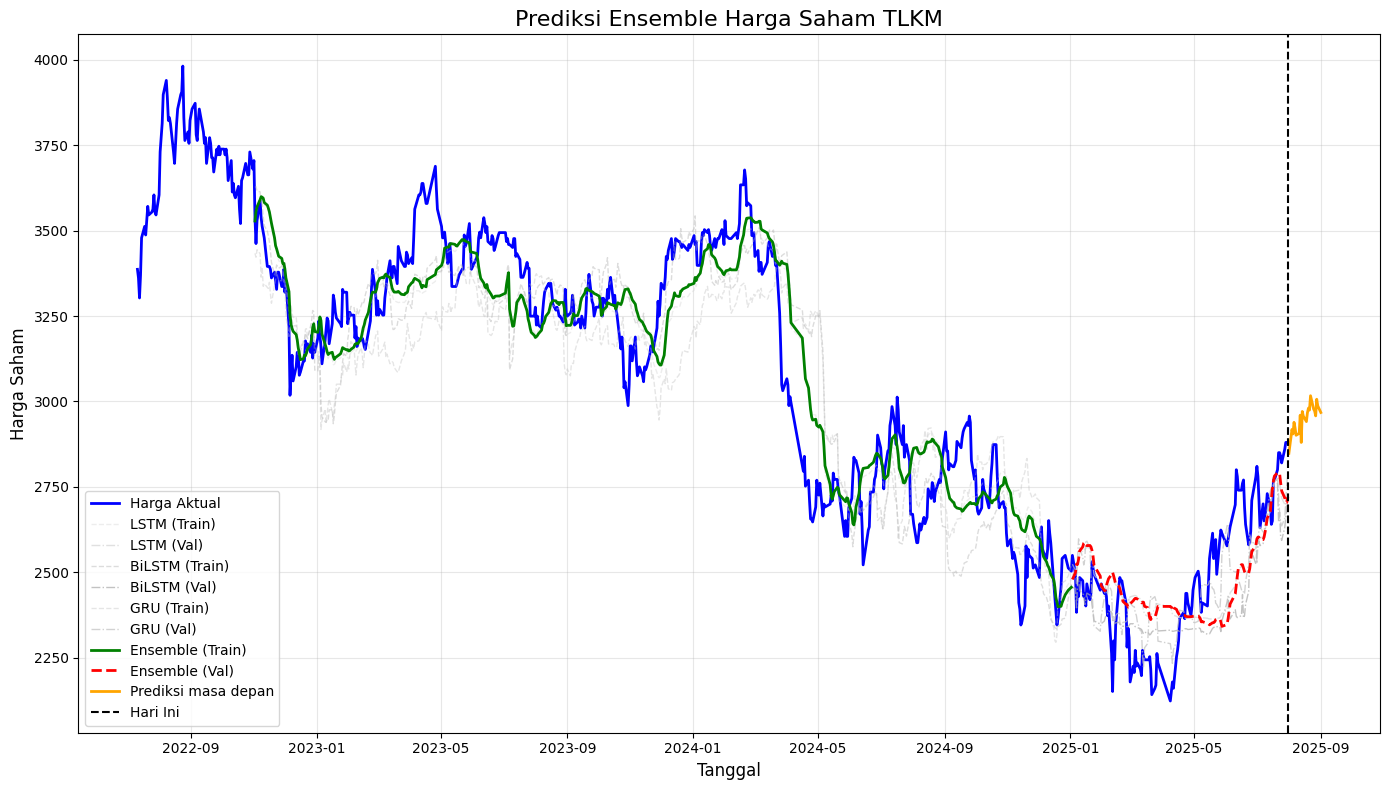

In [ ]:
vs.plot_ensemble_predictions(
    df, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base, TICKER
)

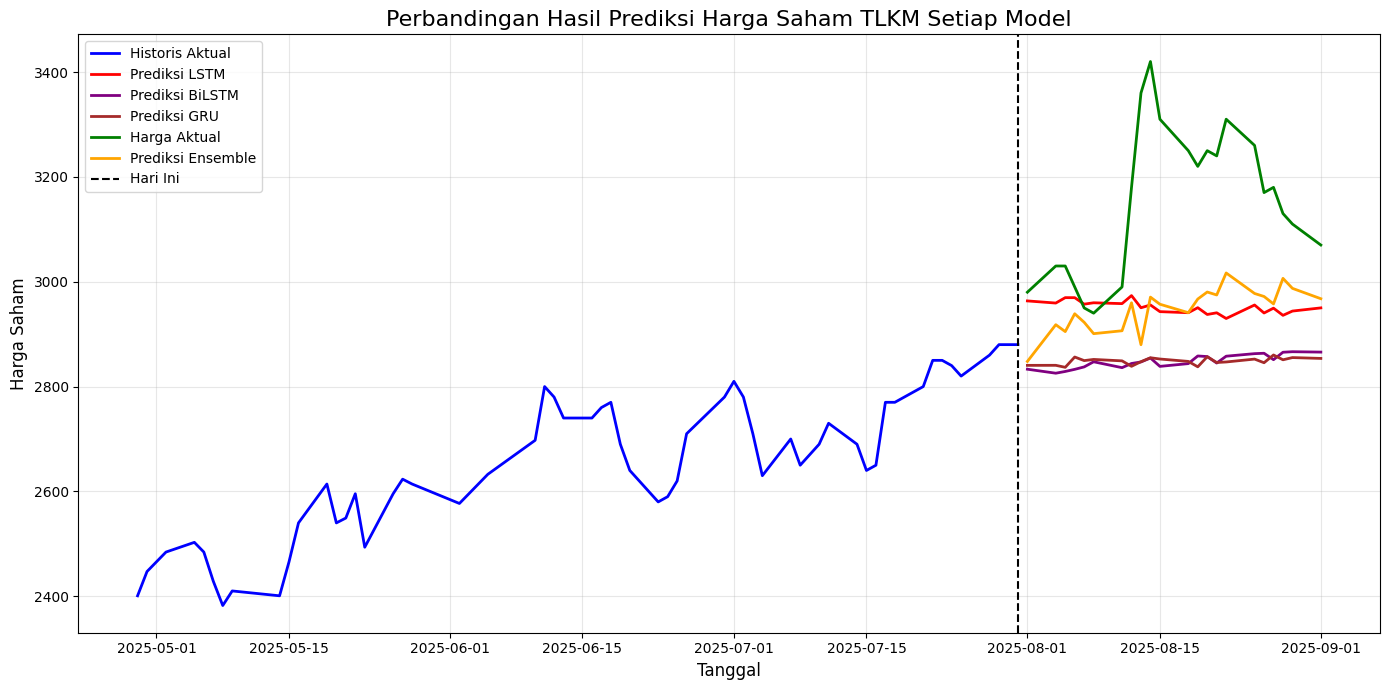

In [ ]:
vs.plot_models_future_comparison(
    df, scaler, future_dates, model_names, y_true,
    future_predictions_individual, future_predictions_base, TICKER
)

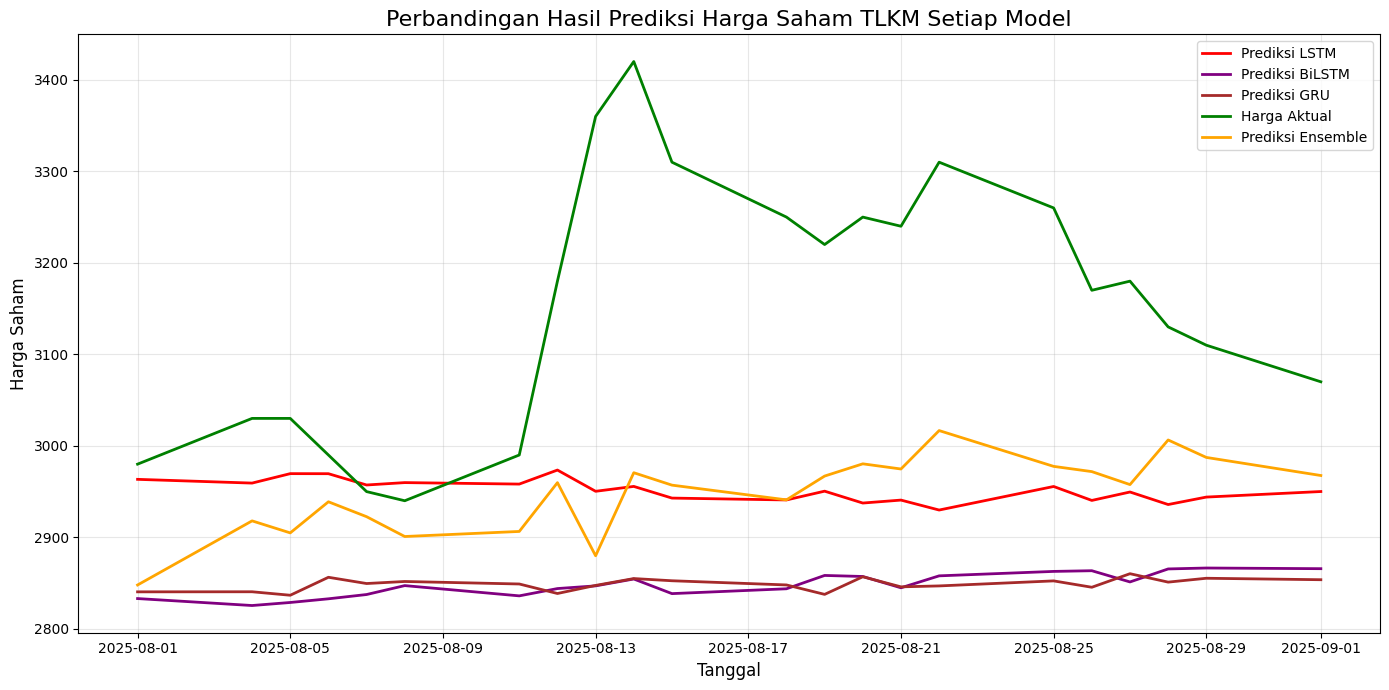

In [ ]:
vs.plot_only_future_comparison(scaler, future_dates, model_names,
                       y_true, future_predictions_individual,
                       future_predictions_base, TICKER
                       )

### Evaluasi

#### Validasi

In [ ]:
y_val_inv = tsp.inverse_scaler(y_val, scaler)
ensemble_preds_hist_val_inv = tsp.inverse_scaler(ensemble_preds_hist_val, scaler)

print(f"Evaluasi hasil prediksi ensemble pada Data Validasi:")
tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

Evaluasi hasil prediksi ensemble pada Data Validasi:
MAE  : 100.6611
MAPE : 4.1471%
MSE  : 15391.0870
RMSE : 124.0608


In [ ]:
for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    y_val_inv = tsp.inverse_scaler(y_val, scaler)
    ensemble_preds_hist_val_inv = tsp.inverse_scaler(pred, scaler)

    print(f"Evaluasi hasil prediksi model {name} pada Data Validasi:")
    tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Evaluasi hasil prediksi model LSTM pada Data Validasi:
MAE  : 98.1216
MAPE : 4.0387%
MSE  : 14221.8627
RMSE : 119.2555
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Evaluasi hasil prediksi model BiLSTM pada Data Validasi:
MAE  : 110.1559
MAPE : 4.4158%
MSE  : 17801.7051
RMSE : 133.4230
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Evaluasi hasil prediksi model GRU pada Data Validasi:
MAE  : 89.6434
MAPE : 3.6470%
MSE  : 12407.1364
RMSE : 111.3873


#### Aktual

In [ ]:
print(f"Evaluasi hasil prediksi ensemble pada Data Aktual:")
tsp.model_evaluate(y_true, y_pred)

Evaluasi hasil prediksi ensemble pada Data Aktual:
MAE  : 205.2170
MAPE : 6.4668%
MSE  : 57313.4890
RMSE : 239.4024


In [ ]:
for name, pred in zip(model_names, future_predictions_individual):
    y_pred_inv = tsp.inverse_scaler(pred, scaler)

    print(f"Evaluasi hasil prediksi model {name} pada Data Aktual:")
    tsp.model_evaluate(y_true, y_pred_inv)

Evaluasi hasil prediksi model LSTM pada Data Aktual:
MAE  : 204.0702
MAPE : 6.2707%
MSE  : 61346.9246
RMSE : 247.6831
Evaluasi hasil prediksi model BiLSTM pada Data Aktual:
MAE  : 304.8747
MAPE : 9.4965%
MSE  : 110586.6482
RMSE : 332.5457
Evaluasi hasil prediksi model GRU pada Data Aktual:
MAE  : 304.4633
MAPE : 9.4834%
MSE  : 111416.7237
RMSE : 333.7914


## INDF

In [ ]:
TICKER = "INDF"

### Persiapan

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,6016.364746,6016.364746,5930.722543,5994.954195,2961000,0.131148
2022-07-12,6037.774414,6080.595509,5973.542771,6037.774414,5209400,0.205047
2022-07-13,5845.080078,5994.953926,5823.669528,5994.953926,10978800,0.204082
2022-07-14,5930.722168,5952.132717,5823.669421,5845.079971,7611600,0.259887
2022-07-15,5909.312500,5952.133605,5845.080842,5930.723053,4235000,0.334204
...,...,...,...,...,...,...
2025-07-25,8400.000000,8400.000000,8300.000000,8350.000000,3388300,-0.212928
2025-07-28,8375.000000,8475.000000,8350.000000,8475.000000,3305800,-0.064327
2025-07-29,8300.000000,8400.000000,8275.000000,8350.000000,3728500,-0.176030


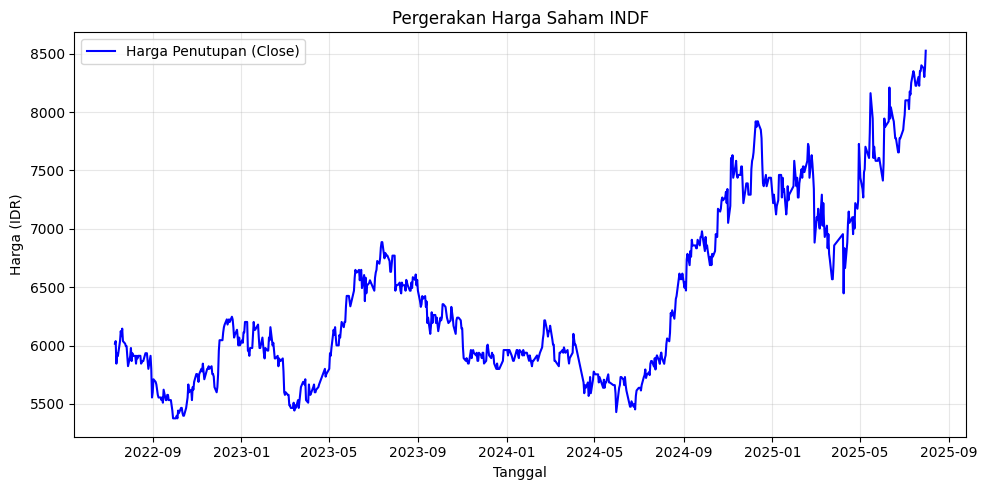

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,6016.364746,2961000,0.131148
2022-07-12,6037.774414,5209400,0.205047
2022-07-13,5845.080078,10978800,0.204082
2022-07-14,5930.722168,7611600,0.259887
2022-07-15,5909.312500,4235000,0.334204
...,...,...,...
2025-07-25,8400.000000,3388300,-0.212928
2025-07-28,8375.000000,3305800,-0.064327
2025-07-29,8300.000000,3728500,-0.176030


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

In [ ]:
lstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_lstm_model.keras")
bilstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_bilstm_model.keras")
gru_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_gru_model.keras")
meta_model = tf.keras.models.load_model(f"./model/{TICKER}/meta_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model_names = ["LSTM", "BiLSTM", "GRU"]
models = [lstm_model, bilstm_model, gru_model]

In [ ]:
individual_predictions_train = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_train)
    individual_predictions_train[name] = pred

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [ ]:
individual_predictions_val = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    individual_predictions_val[name] = pred

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
train_preds = list(individual_predictions_train.values())
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=2)
X_stack_train = X_stack_train.reshape(X_stack_train.shape[0], -1)
X_stack_val = np.stack(val_preds, axis=2)
X_stack_val = X_stack_val.reshape(X_stack_val.shape[0], -1)

In [ ]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
future_predictions_base, future_predictions_individual = tsp.predict_ensemble(
    models, scaler, last_seq, meta_model)

print(future_predictions_base)

[8549.38247187 7876.58215736 7968.42909432 7972.24106057 8094.92133041
 8025.79005667 7439.09649186 7729.375667   7775.2365504  7789.87789372
 7899.81144986 8527.47675531 7719.26878637 8497.06153204 7823.8528663
 7741.46462747 7922.64909299 7474.54779677 7889.43696405 7984.54264141
 8430.34358405 7461.92343829]


In [ ]:
print(future_predictions_individual)

[array([0.6134533 , 0.6329191 , 0.63694507, 0.64187866, 0.6167312 ,
       0.63626266, 0.6139234 , 0.5994126 , 0.60434836, 0.59993327,
       0.59430724, 0.56380045, 0.56294966, 0.54580075, 0.5569875 ,
       0.5313795 , 0.5196532 , 0.4774051 , 0.48543647, 0.48702183,
       0.46529183, 0.46311256], dtype=float32), array([0.89181525, 0.8989247 , 0.9073113 , 0.9242265 , 0.9216368 ,
       0.9346318 , 0.94904757, 0.9621293 , 0.97723216, 0.9710092 ,
       0.97016406, 0.97793096, 0.99010575, 1.0050858 , 1.0135527 ,
       1.0009432 , 1.0177196 , 0.9875594 , 1.0111703 , 0.9988247 ,
       1.0210241 , 1.0214436 ], dtype=float32), array([0.9304263 , 0.9416291 , 0.92383254, 0.886332  , 0.8782157 ,
       0.8942308 , 0.89022076, 0.86810654, 0.84819967, 0.8700782 ,
       0.84899074, 0.855105  , 0.84613353, 0.8438211 , 0.8290441 ,
       0.81501293, 0.80753434, 0.80920595, 0.78057057, 0.75601006,
       0.78229237, 0.7492481 ], dtype=float32)]


In [ ]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base.flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-08-01,8549.382472
2025-08-04,7876.582157
2025-08-05,7968.429094
2025-08-06,7972.241061
2025-08-07,8094.921330
2025-08-08,8025.790057
2025-08-11,7439.096492
2025-08-12,7729.375667
2025-08-13,7775.236550


In [ ]:
df_future  = yf.download(f"{TICKER}.JK", start=start_date, end=end_date)
df_future = df_future[['Close']].dropna()

actual_future = df_future['Close'].head(22).values

/tmp/ipython-input-2396680479.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_future  = yf.download(f"{TICKER}.JK", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
min_len = min(len(future_predictions_base), len(actual_future))

y_true = actual_future[:min_len]
y_pred = future_predictions_base[:min_len]

### Visualisasi

In [ ]:
df_predict_indf = tsp.create_df_predict_future(scaler, future_dates, model_names,
                                             y_true, future_predictions_individual, future_predictions_base)

df_predict_indf

,Tanggal,Prediksi LSTM,Prediksi BiLSTM,Prediksi GRU,Prediksi Ensemble,Harga Aktual
0,2025-08-01,7307.982531,8184.387219,8305.951654,8549.382472,8475.0
1,2025-08-04,7369.269182,8206.770910,8341.222992,7876.582157,8375.0
2,2025-08-05,7381.944772,8233.175621,8285.191611,7968.429094,8325.0
3,2025-08-06,7397.477882,8286.432053,8167.123495,7972.241061,8200.0
4,2025-08-07,7318.302782,8278.278540,8141.569829,8094.921330,8200.0
5,2025-08-08,7379.796236,8319.192481,8191.992386,8025.790057,8150.0
6,2025-08-11,7309.462428,8364.579519,8179.367089,7439.096492,8075.0
7,2025-08-12,7263.776258,8405.766507,8109.741890,7729.375667,8050.0
8,2025-08-13,7279.316124,8453.316906,8047.066357,7775.236550,8025.0
9,2025-08-14,7265.415480,8433.724304,8115.949542,7789.877894,8150.0


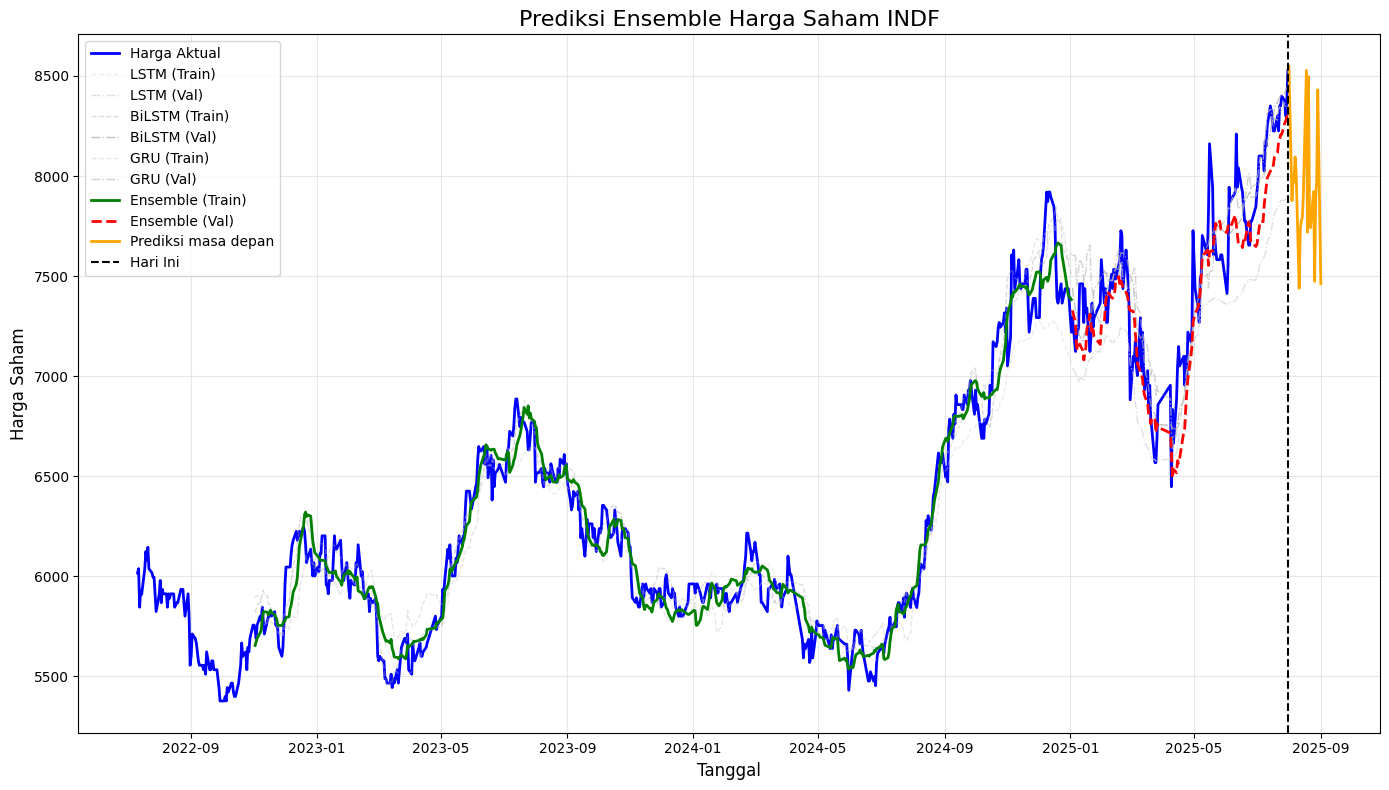

In [ ]:
vs.plot_ensemble_predictions(
    df, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base, TICKER
)

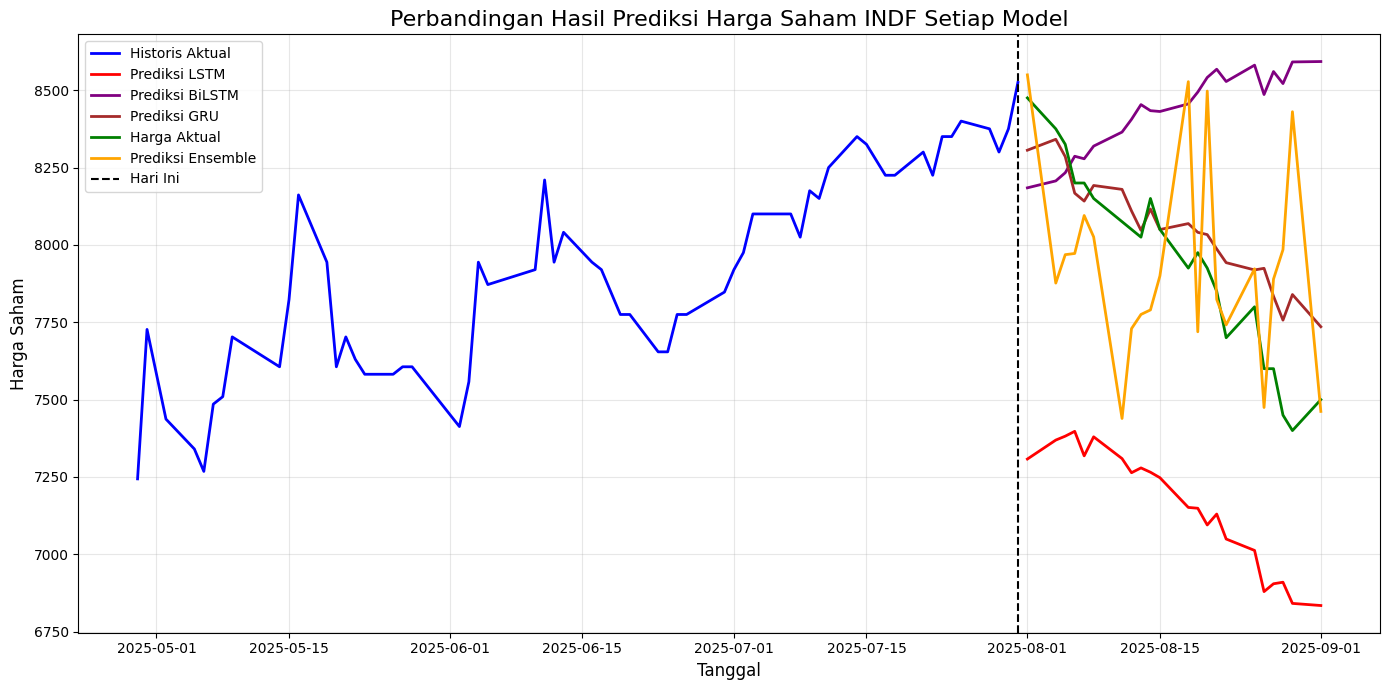

In [ ]:
vs.plot_models_future_comparison(
    df, scaler, future_dates, model_names, y_true,
    future_predictions_individual, future_predictions_base, TICKER
)

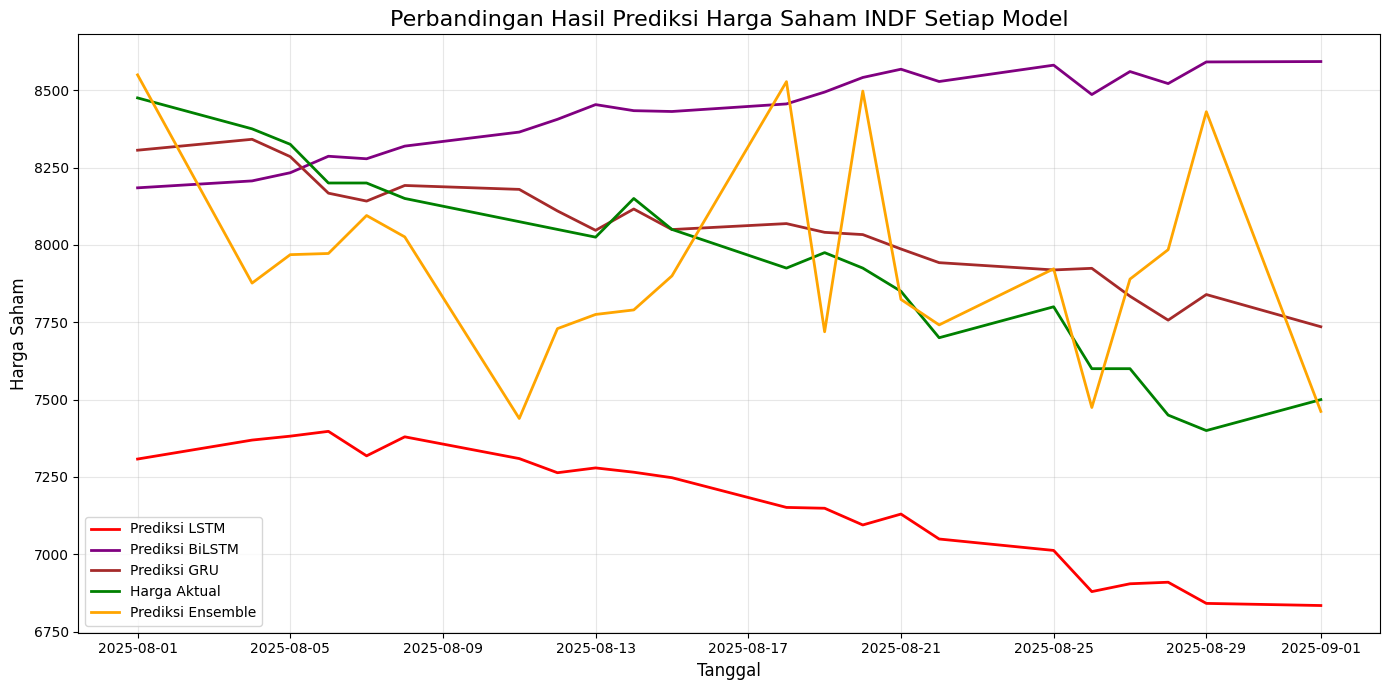

In [ ]:
vs.plot_only_future_comparison(scaler, future_dates, model_names,
                       y_true, future_predictions_individual,
                       future_predictions_base, TICKER
                       )

### Evaluasi

#### Validasi

In [ ]:
y_val_inv = tsp.inverse_scaler(y_val, scaler)
ensemble_preds_hist_val_inv = tsp.inverse_scaler(ensemble_preds_hist_val, scaler)

print(f"Evaluasi hasil prediksi ensemble pada Data Validasi:")
tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

Evaluasi hasil prediksi ensemble pada Data Validasi:
MAE  : 137.4324
MAPE : 1.8385%
MSE  : 30946.0236
RMSE : 175.9148


In [ ]:
for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    y_val_inv = tsp.inverse_scaler(y_val, scaler)
    ensemble_preds_hist_val_inv = tsp.inverse_scaler(pred, scaler)

    print(f"Evaluasi hasil prediksi model {name} pada Data Validasi:")
    tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Evaluasi hasil prediksi model LSTM pada Data Validasi:
MAE  : 331.1843
MAPE : 4.3609%
MSE  : 138556.4472
RMSE : 372.2317
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step 
Evaluasi hasil prediksi model BiLSTM pada Data Validasi:
MAE  : 123.7582
MAPE : 1.6632%
MSE  : 24664.6720
RMSE : 157.0499
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Evaluasi hasil prediksi model GRU pada Data Validasi:
MAE  : 148.2526
MAPE : 1.9991%
MSE  : 36232.3855
RMSE : 190.3481


#### Aktual

In [ ]:
print(f"Evaluasi hasil prediksi ensemble pada Data Aktual:")
tsp.model_evaluate(y_true, y_pred)

Evaluasi hasil prediksi ensemble pada Data Aktual:
MAE  : 306.4274
MAPE : 4.4604%
MSE  : 154664.6218
RMSE : 393.2742


In [ ]:
for name, pred in zip(model_names, future_predictions_individual):
    y_pred_inv = tsp.inverse_scaler(pred, scaler)

    print(f"Evaluasi hasil prediksi model {name} pada Data Aktual:")
    tsp.model_evaluate(y_true, y_pred_inv)

Evaluasi hasil prediksi model LSTM pada Data Aktual:
MAE  : 787.3117
MAPE : 9.7817%
MSE  : 638297.3829
RMSE : 798.9352
Evaluasi hasil prediksi model BiLSTM pada Data Aktual:
MAE  : 537.0833
MAPE : 6.4205%
MSE  : 408644.2520
RMSE : 639.2529
Evaluasi hasil prediksi model GRU pada Data Aktual:
MAE  : 134.2253
MAPE : 3.6267%
MSE  : 31131.8109
RMSE : 176.4421


## GOTO

In [ ]:
TICKER = "GOTO"

### Persiapan

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,338.0,354.0,334.0,354.0,840928300,0.086957
2022-07-12,330.0,338.0,330.0,338.0,802215500,0.127820
2022-07-13,324.0,330.0,320.0,330.0,870421000,-0.022727
2022-07-14,332.0,336.0,320.0,324.0,786358600,-0.090032
2022-07-15,320.0,336.0,320.0,332.0,998698500,-0.024390
...,...,...,...,...,...,...
2025-07-25,58.0,59.0,57.0,59.0,5090425000,-0.165906
2025-07-28,59.0,60.0,58.0,58.0,3567335000,-0.139048
2025-07-29,59.0,60.0,58.0,59.0,1423009300,-0.040984


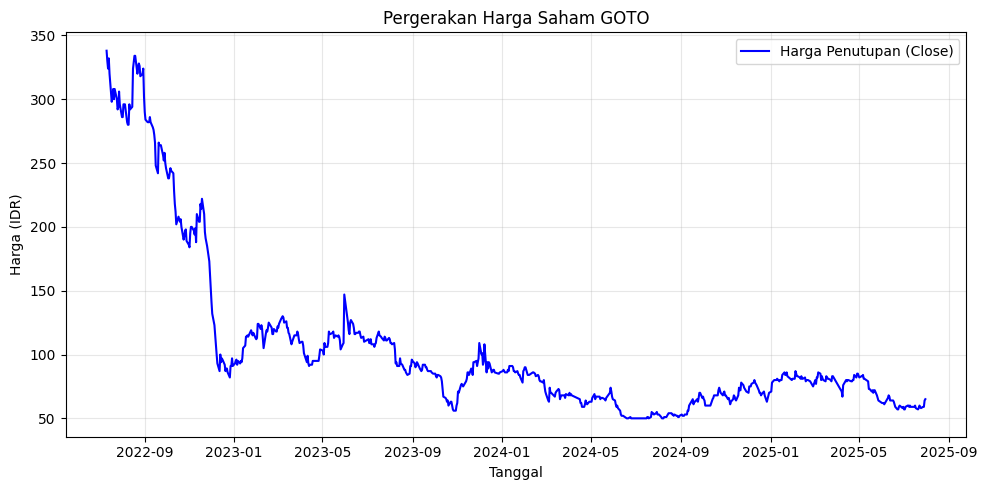

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,338.0,840928300,0.086957
2022-07-12,330.0,802215500,0.127820
2022-07-13,324.0,870421000,-0.022727
2022-07-14,332.0,786358600,-0.090032
2022-07-15,320.0,998698500,-0.024390
...,...,...,...
2025-07-25,58.0,5090425000,-0.165906
2025-07-28,59.0,3567335000,-0.139048
2025-07-29,59.0,1423009300,-0.040984


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

In [ ]:
lstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_lstm_model.keras")
bilstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_bilstm_model.keras")
gru_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_gru_model.keras")
meta_model = tf.keras.models.load_model(f"./model/{TICKER}/meta_model.keras")

In [ ]:
model_names = ["LSTM", "BiLSTM", "GRU"]
models = [lstm_model, bilstm_model, gru_model]

In [ ]:
individual_predictions_train = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_train)
    individual_predictions_train[name] = pred

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [ ]:
individual_predictions_val = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    individual_predictions_val[name] = pred

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
train_preds = list(individual_predictions_train.values())
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=2)
X_stack_train = X_stack_train.reshape(X_stack_train.shape[0], -1)
X_stack_val = np.stack(val_preds, axis=2)
X_stack_val = X_stack_val.reshape(X_stack_val.shape[0], -1)

In [ ]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
future_predictions_base, future_predictions_individual = tsp.predict_ensemble(
    models, scaler, last_seq, meta_model)

print(future_predictions_base)

[60.54244506 57.84940797 58.15402484 58.72764152 57.99350858 56.61963499
 58.03387153 57.78122461 55.94326234 56.90746015 54.87438273 60.17609072
 61.96770012 57.10508585 56.6806488  57.25663871 58.98541898 54.82665497
 57.52012122 57.89235497 59.18242455 56.57588708]


In [ ]:
print(future_predictions_individual)

[array([0.02323034, 0.02399921, 0.02340086, 0.02422511, 0.02384998,
       0.01886505, 0.01582409, 0.02074426, 0.01554363, 0.0191778 ,
       0.01952969, 0.01802225, 0.01644202, 0.0198901 , 0.01956964,
       0.02243819, 0.02661196, 0.0277734 , 0.02580415, 0.02934964,
       0.02946292, 0.02627299], dtype=float32), array([0.03456267, 0.03487237, 0.0402139 , 0.03536018, 0.03740005,
       0.03751125, 0.04019954, 0.03686   , 0.03928972, 0.03747016,
       0.03730293, 0.03607852, 0.04375874, 0.04211439, 0.03964397,
       0.0394091 , 0.03903938, 0.03621398, 0.03629506, 0.03933956,
       0.04473539, 0.04217808], dtype=float32), array([0.03432883, 0.04097559, 0.03576422, 0.0421581 , 0.03851255,
       0.0344632 , 0.03430749, 0.03841432, 0.0350442 , 0.02975423,
       0.03429315, 0.04046599, 0.03376753, 0.03365401, 0.03324396,
       0.03742364, 0.03447034, 0.04034023, 0.0432893 , 0.04127944,
       0.04557831, 0.03809072], dtype=float32)]


In [ ]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base.flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-08-01,60.542445
2025-08-04,57.849408
2025-08-05,58.154025
2025-08-06,58.727642
2025-08-07,57.993509
2025-08-08,56.619635
2025-08-11,58.033872
2025-08-12,57.781225
2025-08-13,55.943262


In [ ]:
df_future  = yf.download(f"{TICKER}.JK", start=start_date, end=end_date)
df_future = df_future[['Close']].dropna()

actual_future = df_future['Close'].head(22).values

/tmp/ipython-input-2396680479.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_future  = yf.download(f"{TICKER}.JK", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
min_len = min(len(future_predictions_base), len(actual_future))

y_true = actual_future[:min_len]
y_pred = future_predictions_base[:min_len]

### Visualisasi

In [ ]:
df_predict_goto = tsp.create_df_predict_future(scaler, future_dates, model_names,
                                             y_true, future_predictions_individual, future_predictions_base)

df_predict_goto

,Tanggal,Prediksi LSTM,Prediksi BiLSTM,Prediksi GRU,Prediksi Ensemble,Harga Aktual
0,2025-08-01,56.690339,59.954050,59.886702,60.542445,65.0
1,2025-08-04,56.911773,60.043242,61.800971,57.849408,63.0
2,2025-08-05,56.739448,61.581604,60.300097,58.154025,65.0
3,2025-08-06,56.976832,60.183732,62.141532,58.727642,65.0
4,2025-08-07,56.868794,60.771215,61.091614,57.993509,63.0
5,2025-08-08,55.433134,60.803241,59.925401,56.619635,62.0
6,2025-08-11,54.557339,61.577468,59.880558,58.033872,62.0
7,2025-08-12,55.974347,60.615679,61.063325,57.781225,65.0
8,2025-08-13,54.476567,61.315438,60.092731,55.943262,64.0
9,2025-08-14,55.523207,60.791407,58.569218,56.907460,62.0


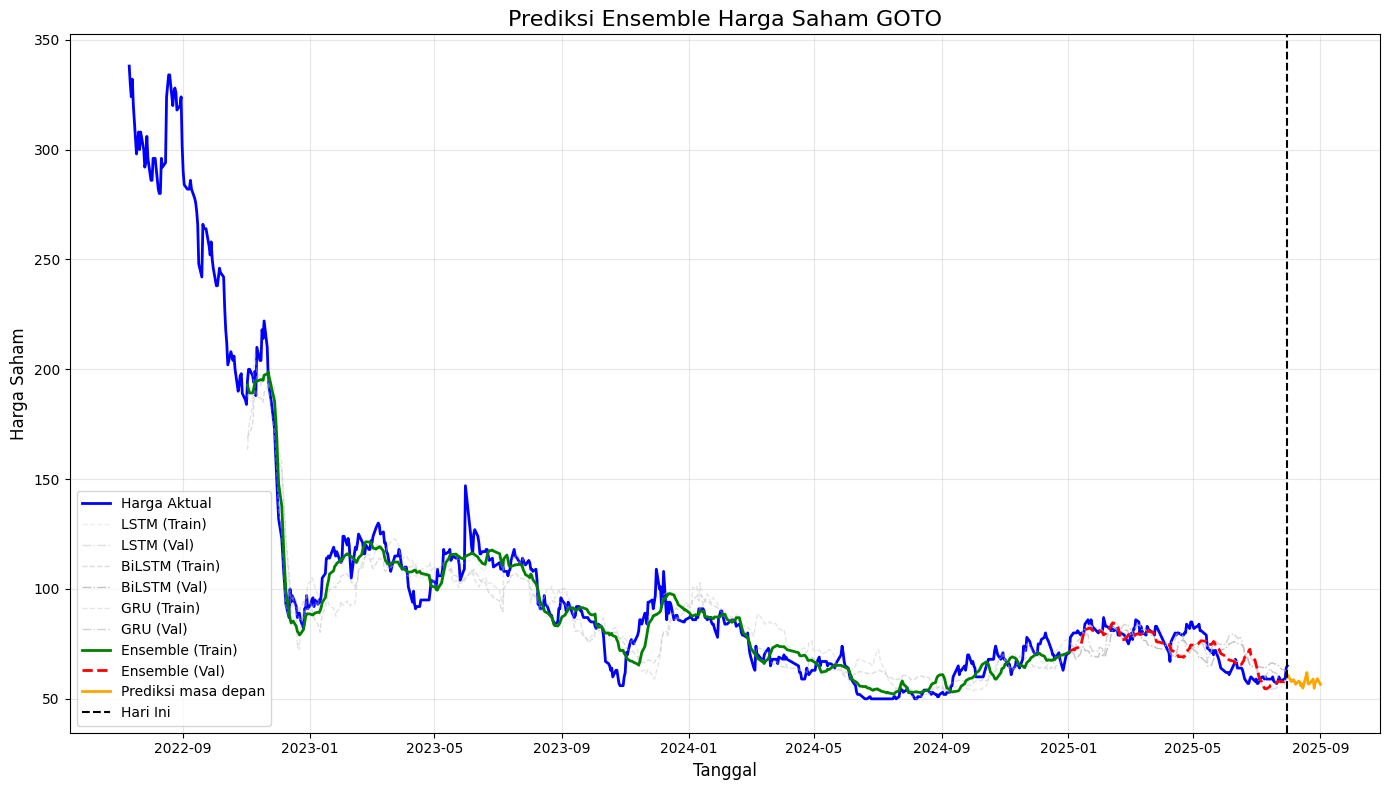

In [ ]:
vs.plot_ensemble_predictions(
    df, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base, TICKER
)

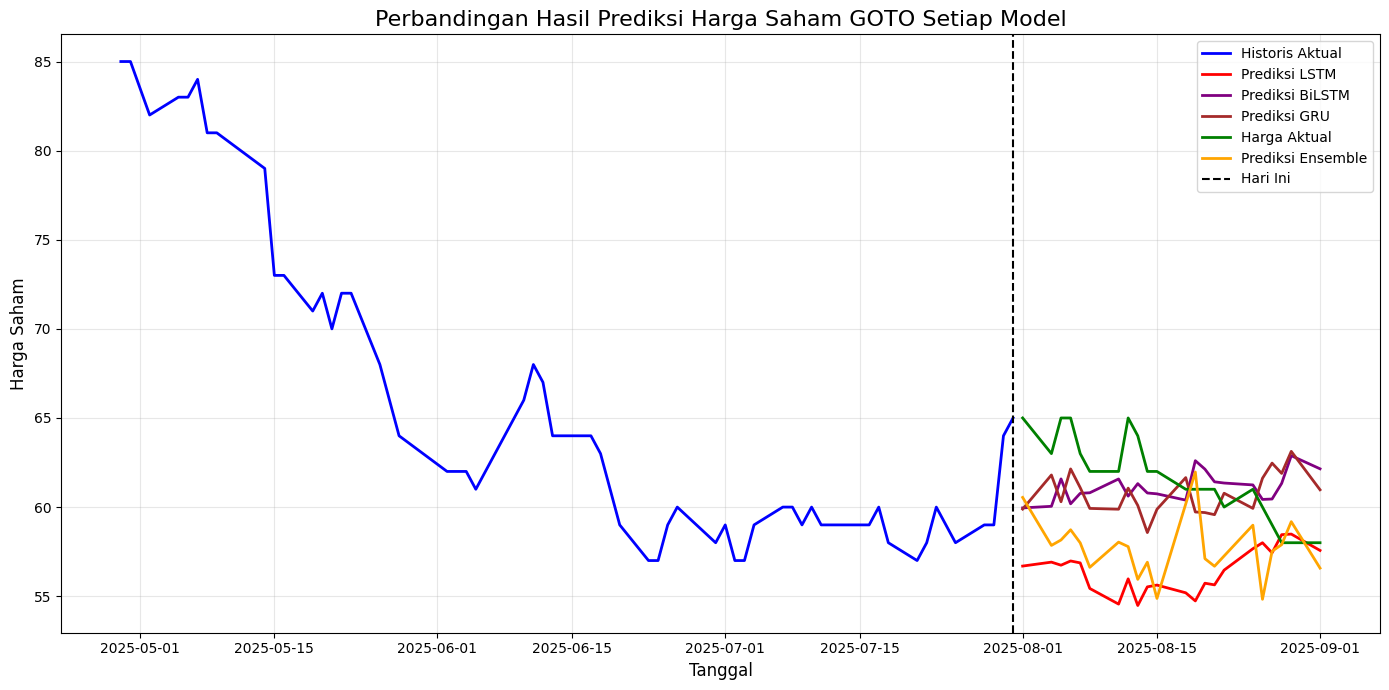

In [ ]:
vs.plot_models_future_comparison(
    df, scaler, future_dates, model_names, y_true,
    future_predictions_individual, future_predictions_base, TICKER
)

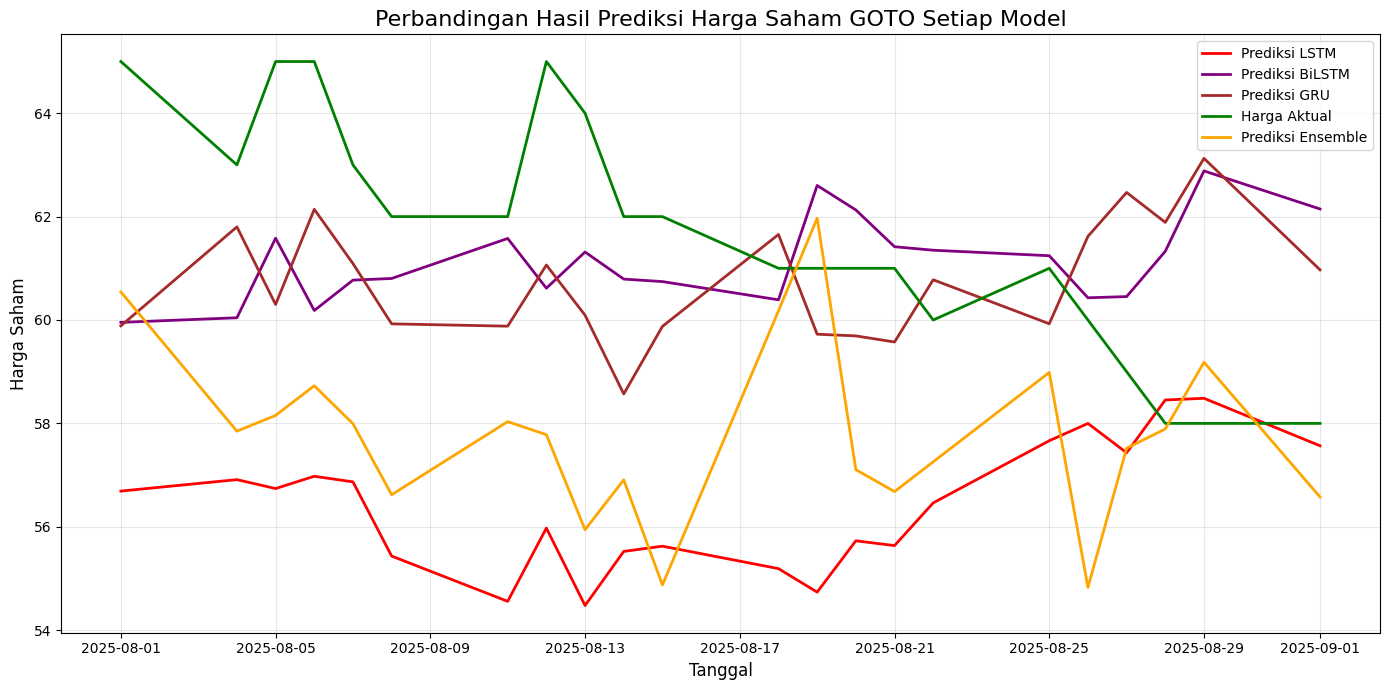

In [ ]:
vs.plot_only_future_comparison(scaler, future_dates, model_names,
                       y_true, future_predictions_individual,
                       future_predictions_base, TICKER
                       )

### Evaluasi

#### Validasi

In [ ]:
y_val_inv = tsp.inverse_scaler(y_val, scaler)
ensemble_preds_hist_val_inv = tsp.inverse_scaler(ensemble_preds_hist_val, scaler)

print(f"Evaluasi hasil prediksi ensemble pada Data Validasi:")
tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

Evaluasi hasil prediksi ensemble pada Data Validasi:
MAE  : 3.8895
MAPE : 5.3066%
MSE  : 24.1065
RMSE : 4.9098


In [ ]:
for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    y_val_inv = tsp.inverse_scaler(y_val, scaler)
    ensemble_preds_hist_val_inv = tsp.inverse_scaler(pred, scaler)

    print(f"Evaluasi hasil prediksi model {name} pada Data Validasi:")
    tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Evaluasi hasil prediksi model LSTM pada Data Validasi:
MAE  : 3.6543
MAPE : 4.9566%
MSE  : 20.7016
RMSE : 4.5499
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Evaluasi hasil prediksi model BiLSTM pada Data Validasi:
MAE  : 6.0573
MAPE : 8.0738%
MSE  : 56.8682
RMSE : 7.5411
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Evaluasi hasil prediksi model GRU pada Data Validasi:
MAE  : 4.6973
MAPE : 6.4045%
MSE  : 37.7159
RMSE : 6.1413


#### Aktual

In [ ]:
print(f"Evaluasi hasil prediksi ensemble pada Data Aktual:")
tsp.model_evaluate(y_true, y_pred)

Evaluasi hasil prediksi ensemble pada Data Aktual:
MAE  : 4.0320
MAPE : 6.4642%
MSE  : 21.6136
RMSE : 4.6490


In [ ]:
for name, pred in zip(model_names, future_predictions_individual):
    y_pred_inv = tsp.inverse_scaler(pred, scaler)

    print(f"Evaluasi hasil prediksi model {name} pada Data Aktual:")
    tsp.model_evaluate(y_true, y_pred_inv)

Evaluasi hasil prediksi model LSTM pada Data Aktual:
MAE  : 5.3067
MAPE : 8.3716%
MSE  : 35.9038
RMSE : 5.9920
Evaluasi hasil prediksi model BiLSTM pada Data Aktual:
MAE  : 2.2370
MAPE : 3.1755%
MSE  : 7.5381
RMSE : 2.7456
Evaluasi hasil prediksi model GRU pada Data Aktual:
MAE  : 2.5889
MAPE : 3.4707%
MSE  : 8.6246
RMSE : 2.9368
